# Exercise 3
All previous instructions hold. In addition, if you are using GPU, you must check that your code also runs on a CPU. 

**Make sure you use the best practices you learned in class**.

In this exercise, you will accomplish the following:
1. Train a convolutional network using PyTorch and evaluate it.
2. Visualize a neural network layer and interpet their meaning.

In [3]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as T
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.metrics import confusion_matrix as confusion_matrix_fn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is {device}")

Device is cuda


# Convolutional Neural Network - Classifiying CIFAR-10 (60 points)

So far we had to manually implement both the forward and backward passes of our neural network. Manually implementing the backward pass is not a big deal for a small two-layer network, but can quickly get very messy for large complex networks.

Thankfully, we can use **automatic differentiation** to automate the computation of backward passes in neural networks. The autograd package in PyTorch provides exactly this functionality. When using autograd, the forward pass of your network will define a computational graph. Nodes in the graph will be Tensors,
and edges will be functions that produce output Tensors from input Tensors. Backpropagating through this graph then allows you to easily compute gradients.

If we want to compute gradients with respect to some Tensor, then we set `requires_grad=True` when constructing that Tensor. Any PyTorch operations on that Tensor will cause a computational graph to be constructed, allowing us to later perform backpropagation through the graph. If `x` is a Tensor with `requires_grad=True`, then after backpropagation `x.grad` will be another Tensor holding the gradient of `x`.

Sometimes you may wish to prevent PyTorch from building computational graphs when performing certain operations on Tensors with `requires_grad=True`; for example, we usually don't want to backpropagate through the weight update steps when evaluating a neural network. In such scenarios we can use the `torch.no_grad()` context manager to prevent the construction of a computational graph.


## Data Preprocessing

In [56]:
transform = T.Compose(
    [T.ToTensor(),
     T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Image shape:  torch.Size([3, 32, 32])
       dog      plane      truck       deer


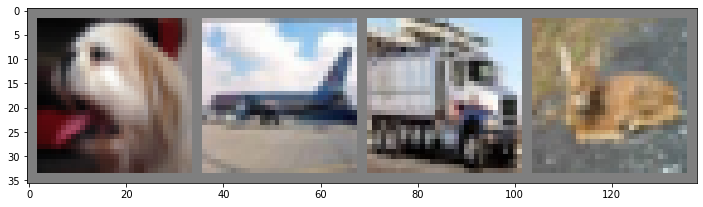

In [57]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # plt accepts images in the format (w,h,c)
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print("Image shape: ", images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

## Construct a CNN in PyTorch - 30 points

In the following class, initiate your different layers in the `__init__` method and define your architecture in the `forward` method. Make sure the `forward` method has a single return value. 

1. Make good use of the documentation and experiment will different layers, activations and architectures, batch sizes, regularization, filter sizes, dimensions, number of layers and whatever you learned in class. 
1. Use your intuition from the previous exercises and additional sources such as the Piazza, papers, etc. - do not try to perform a massive grid search.
1. **Your model must end with two linear layers. (with activations between them)**.
1. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
1. Make sure your code runs reasonably fast (~30 minutes on CPU and ~5 minutes on GPU).
1. Use the best architecture you find and train it for 5-10 epochs. 
1. Explain why you chose that architecture and why you think it performs better than other networks you tried. Cite papers, blogs, MOOCs, online guides and every other source you used during optimization.
1. Visualize the loss and accuracy of your network during training. You can use matplotlib or seaborn.
1. **You should get close to 75% accuracy, explain you results and include visualizations for the full 30 points**.

In [58]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Initiate the different layers you wish to use in your network.            #
        # This method has no return value.                                          #
        #############################################################################
   

        self.cnn_layers = nn.Sequential(
            
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(p=0.05),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.05),
            
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )

        self.fc_layers = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
        )

        self.last_fc_layer = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def feature_extraction(self, x):
        #############################################################################
        # TO DO:                                                                    #
        # Pass through the image x thghrough all layers except the last one         #
        # and the activation between it and the previous linear layer.              #
        # This way we can extract the feature space that the network generetes      #
        # before the final prediction.                                              #
        #############################################################################

        # conv layers
        x = self.cnn_layers(x)
        # flatten
        x = x.view(x.size(0), -1)
        # fc layer
        x = self.fc_layers(x)
        
        return x
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def forward(self, x):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and obtain class predictions.                                     #
        # This function returns the predication of your model.                      #
        #############################################################################
        
        self.final_feature_map = self.feature_extraction(x)
        x = self.last_fc_layer(self.final_feature_map)
        return x
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

net = Net().to(device)
criterion = None
optimizer = None
#############################################################################
# TO DO:                                                                    #
# Define the loss function and optimizer.                                   #
# You are encouraged to experiment with different optimizers                #
#############################################################################
# defining the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0001)
# defining the loss function
criterion = nn.CrossEntropyLoss()
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

### The Architecture is as follows:

In [59]:
print(net)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout2d(p=0.05, inplace=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14):

The chosen architecture is based on examples from class, and using the following references:

[1] https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7
[2] https://theaisummer.com/cnn-architectures/ 

For finding the best network, I’ve experiemented with several architectures and hyper-parameters combinations. AlextNet and the VGG models that were shown in class were used as an insperation while I’ve tried to build a smaller model with less layers due computitional limitations. The network has 5 convolutional layers with Batch Normalization and Max Pooling for each layer which improved the performance. In addition, increasing the number of layers had significantly positive effect on the performance but increase the training time as well. I’ve experimented with different optimizers while Adam which is the most common found to be the best. I tried different loss fuctions and chose the Cross Entropy Loss. I’ve eperimented also with other hyper-parameters such as learning rate, batch size and epochs number and different activation functions. Below I elaborate about the different variables and the insight I gained during training, online research and from class. 

- Batch Normslization: as studied in class, it prevents exploding and vanishing gradients and accelerates convergence of training. Therefore, I added a normalizaion after each of the convolutional layers before the activation functions. It normelizes the input, speeds up the learning and make the layer to become more independant from the other layers. In addition to accelerates the convergence of training, it makes training more robust w.r.t. hyperparameter choice, weight initialization.
- Softmax and cross entropy: as studied in class and in the previous assignments, we typically combine the softmax and cross-entropy into softmax-cross entropy function. Therefore, I chose to use it as the final activation.
- Dropout: as learned in class and as in the original paper that proposed dropout layers, by Hinton (2012), dropout was used.
- Pooling: Max-Pooling is the most common among all the pooling options. Max Pooling reduced the computation time drastically. Pooling layers have filters of 3x3 and stride of 2 as in Alex net. The objective is to down-sample the input representation reducing its dimensionality by keeping the max value (activated features) in the sub-regions binned.
- Stride and padding: as learned, the convolutional layer output size is $((N-F+2P)/stride)+1$. In order to keep the output dimension equal with the 3x3 filter size I used a padding and a stride of 1. 
- Filter size: as learned in class, smaller filters gives less computation time, fewer parameters. I've used a small kernel filters of 3x3 as in the VGG architecture.
- Activation function: as in AlexNet architecture and as recommended in class, I chose to use the ReLU nonlinearity function and as previously mentioned I used softmax for the final layer.
- Convolutional dimensions: gradually increasing the dimension from 32 to 64, 128, 256 and 256. Increasing it further exceeds the given training time. Also, gradually increasing the channel size is aligned with the architectures we learned about. As seen in class for the VGG-16 and as mentioned in [1], a good principle is layers are getting spatially smaller and channels are getting deeper. Keeping the feature space wide and shallow in the initial stages of the network and then, make it narrower and deeper towards the end. 


In [60]:
%%time
#############################################################################
# TO DO:                                                                    #
# Define the training loop as seen in class and as demonstrated in the      #
# documentation. Note, if you are using GPU, make sure your code runs on    #
# CPU also. Code that cannot run will not be tested.                        # 
#############################################################################
epochs_num = 6
n_samples = len(trainset)
train_loss_per_epoch = []
train_accuracy_per_epoch = []

for epoch in range(epochs_num): 
    running_loss = 0.0
    train_loss = 0.0
    correct = 0.0
    for i, data in enumerate(trainloader, 0):
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        # predict on training set
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

        # backward + optimize        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_loss += loss.item()

        # print statistics
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    train_loss_per_epoch.append(train_loss)
    train_accuracy_per_epoch.append(correct/n_samples)
print('Finished Training')

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

Finished Training
CPU times: user 3min 38s, sys: 4.64 s, total: 3min 43s
Wall time: 3min 50s


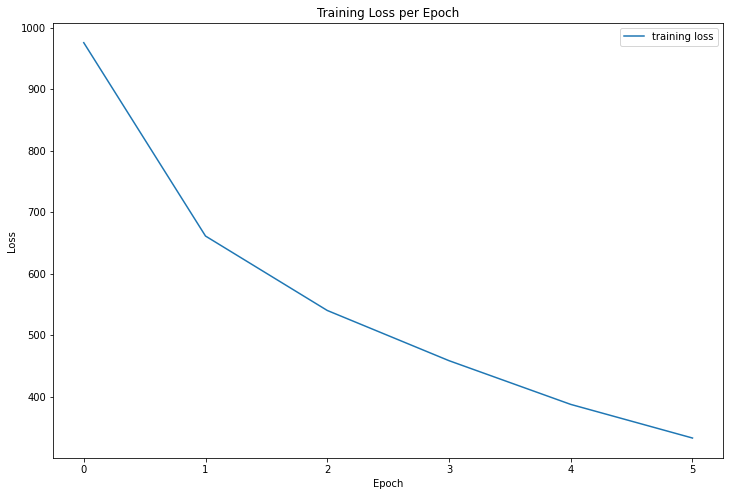

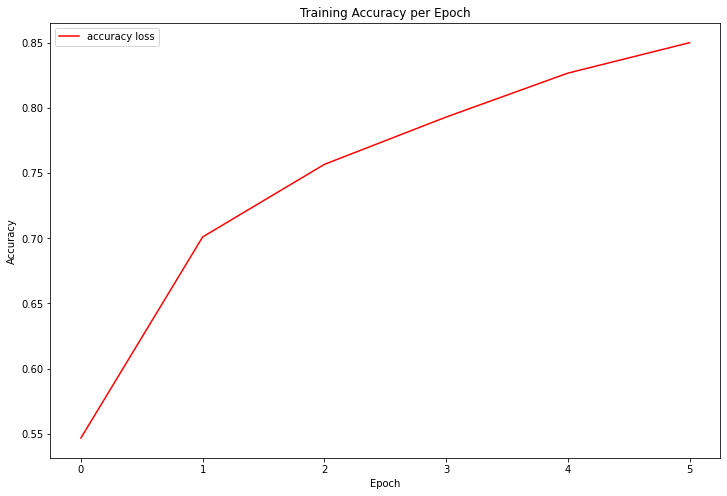

In [62]:
# Plot the training loss convergence
plt.plot(train_loss_per_epoch, label='training loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.show()

# Plot the training loss convergence
plt.plot(train_accuracy_per_epoch, color='red', label='accuracy loss')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy per Epoch")
plt.legend()
plt.show()

GroundTruth:      cat    ship    ship   plane
Predicted:        cat    ship    ship   plane


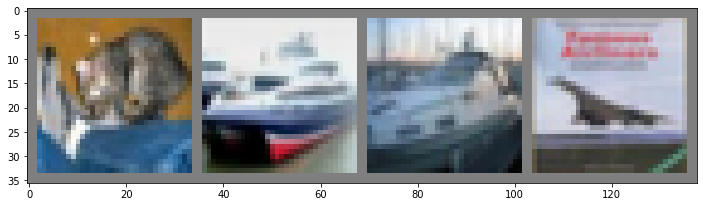

In [63]:
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%7s' % classes[labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)
print('Predicted:   ', ' '.join('%7s' % classes[predicted[j]] for j in range(4)))

## Model Class Performance Evaluation - 15 points

1. Calculate the confusion matrix for the model. You are allowed to use loops.
1. Calculate and print the model's overall accuracy and the accuracy for each class.
1. Plot the confusion matrix with matplotlib where the y axis represents the real category and the x axis represents the predicted category and print the accuracies. (make sure the rows and columns are labeled with the proper class names).
1. **Explain the results**: what can you learn from the confusion matrix? Why do you need additional evaluation methods other than accuracy?

In [64]:
confusion_matrix = np.zeros([10,10], int)
#############################################################################
# TO DO:                                                                    #
# Define the evaluation loop as seen in class and as demonstrated in the    #
# documentation and use the confusion matrix to evaluate your model.        # 
#############################################################################

def calc_net_accuracy(net, testloader):
    preds = []
    actuals = []
    with torch.no_grad():
        correct = 0
        total = 0
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            preds.append(predicted.cpu().numpy())
            actuals.append(labels.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
    return np.concatenate(preds, axis=0), np.concatenate(actuals, axis=0)

predictions, labels = calc_net_accuracy(net, testloader)

confusion_matrix = confusion_matrix_fn(labels, predictions, normalize='true')#,
                            #  labels=classes)


#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

Accuracy of the network on the 10000 test images: 78 %


plane: accuracy: 85.0%
car: accuracy: 85.6%
bird: accuracy: 64.1%
cat: accuracy: 52.2%
deer: accuracy: 71.4%
dog: accuracy: 80.1%
frog: accuracy: 81.5%
horse: accuracy: 87.8%
ship: accuracy: 88.0%
truck: accuracy: 89.1%


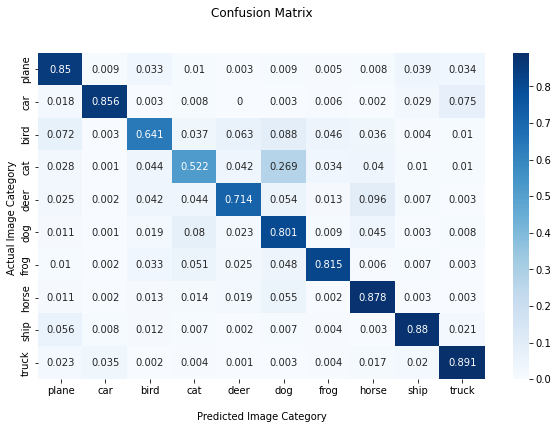

In [65]:
#############################################################################
# TO DO:                                                                    #
# plot the confusion matrix, use labels to show what is the predicted\actual#
# and label each row column with the correct class description              #
# documentation and use the confusion matrix to evaluate your model.        # 
#############################################################################

# print all classes accuracies
for class_i, row in enumerate(confusion_matrix):
    print(f'{classes[class_i]}: accuracy: {np.round(row[class_i]/np.sum(row)*100, 2)}%')


plt.figure(figsize=(10,6))
ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', vmin=0, fmt='g')
# ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Image Category')
ax.set_ylabel('Actual Image Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)

## Display the visualization of the Confusion Matrix.
plt.show()
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

One can see that there are some classes in which the model is less accurate than in the others. For example, for the ‘cat’ class the model misses much more. An overall accuracy metric doesn’t show the whole picture and from the score, we can’t tell the actual performance per each class. It's important to differentiate the model performance between the different clases so we can train the model to better generelize on classes that the model is weaker on. Moreover, it allows to detect cases in such the model has more tendency to misclassified between specific classes, i.e. the errors distribution in each class. This kind of analysis is given by a confusion matrix.

## Visualizing and Evaluating the Model's latent space - 15 points

In order to furether evaluate our network's model performance, we would like to visualize its feature's latent space in 2d and see which classes are close to each other. In order to accomplish this we are going to use the "T-SNE" algorithem to project our feature space to a lower dimension.

1. Set the model to evaluation mode and use the feature_extraction method to get the feature representation of the 10,000 test set images using the feature_extraction method.

2. Read the documentation of "https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html" and use T-SNE to project the images from the high dimensional feature space to the lower dimensional feature space.

3. Visualize the image distrubtion in the 2d space by plotting each image with the color of its label (total 10 labels\colors) using matplotlib scatter plot.

4. What can you learn from the plot? is it consistent with the confusion matrix?

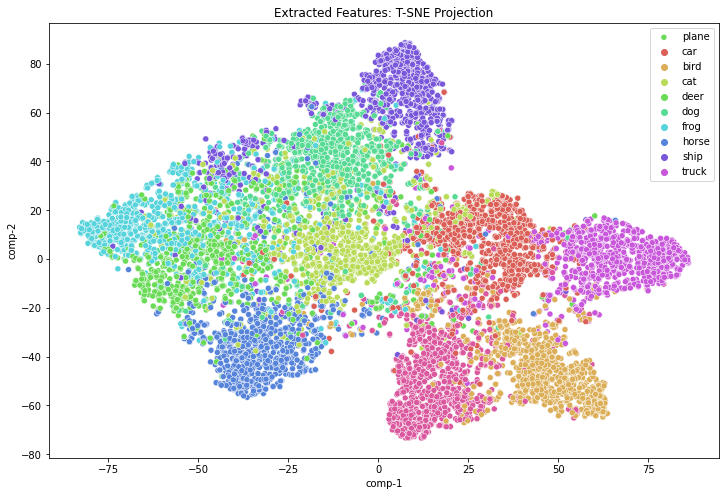

In [68]:
# your code goes here

def extract_features(net, testloader):
    features_extracted = []
    with torch.no_grad():
        correct = 0
        total = 0
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            # _, predicted = torch.max(outputs.data, 1)
            features_extracted.append(net.final_feature_map.cpu())

    return np.concatenate(features_extracted, axis=0)



X_features_extracted = extract_features(net, testloader)
X_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random').fit_transform(X_features_extracted)

df = pd.DataFrame()
df["y"] = labels
df["comp-1"] = X_embedded[:,0]
df["comp-2"] = X_embedded[:,1]

## add labels on the cluster
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", len(classes)),
                data=df).set(title="Extracted Features: T-SNE Projection")
plt.legend(labels=classes);


**Your answer to 4 goes here**

One can see that each class has its own cluster. Furthermore, classes which the model misclassify between according to the confusion matrix, such as dog with cat, are geometrically close to each other. It is indeed consistent with the confusion matrix findings.


# Network Visualization - 40 points

In this part we are going to load a pretrained model classifier model called SqueezeNet and explore the meaning (and some would say intent) behind the calculation in its layer's.

1. **Saliency Maps**: Saliency maps are a quick way to tell which part of the image influenced the classification decision made by the network.
1. **Fooling Images**: We can perturb an input image so that it appears the same to humans, but will be misclassified by the pretrained network.



In [69]:
!wget https://raw.githubusercontent.com/Oringa/pytorch_workshop/master/imagenet_val_25.npz

--2021-12-12 13:00:39--  https://raw.githubusercontent.com/Oringa/pytorch_workshop/master/imagenet_val_25.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3940548 (3.8M) [application/octet-stream]
Saving to: ‘imagenet_val_25.npz’

imagenet_val_25.npz 100%[===================>]   3.76M  --.-KB/s    in 0.07s   

2021-12-12 13:00:39 (53.8 MB/s) - ‘imagenet_val_25.npz’ saved [3940548/3940548]




## Helper Functions

Our pretrained model was trained on images that had been preprocessed by subtracting the per-color mean and dividing by the per-color standard deviation. We define a few helper functions for performing and undoing this preprocessing. 

In [70]:
def preprocess(img, size=224):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled
    
def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

## Pretrained model

For all of our image generation experiments, we will start with a convolutional neural network which was pretrained to perform image classification on ImageNet. We can use any model here, but for the purposes of this assignment we will use [SqueezeNet](https://arxiv.org/abs/1602.07360), which achieves accuracies comparable to AlexNet but with a significantly reduced parameter count and computational complexity.

Using SqueezeNet rather than AlexNet, VGG or ResNet means that we can easily perform all image generation experiments on CPU.

In [71]:
# Download and load the pretrained SqueezeNet model.
model = torchvision.models.squeezenet1_1(pretrained=True)

# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in model.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


  0%|          | 0.00/4.73M [00:00<?, ?B/s]

## Load some ImageNet images

We have provided a few example images from the validation set of the ImageNet ILSVRC 2012 Classification dataset. Since they come from the validation set, our pretrained model did not see these images during training.

In [73]:
import numpy as np

def load_imagenet_val(num=None):
    """Load a handful of validation images from ImageNet.
    Inputs:
    - num: Number of images to load (max of 25)
    Returns:
    - X: numpy array with shape [num, 224, 224, 3]
    - y: numpy array of integer image labels, shape [num]
    - class_names: dict mapping integer label to class name
    """
    imagenet_fn = 'imagenet_val_25.npz'
    f = np.load(imagenet_fn, allow_pickle=True)
    X = f['X']
    y = f['y']
    class_names = f['label_map'].item()
    if num is not None:
        X = X[:num]
        y = y[:num]
    return X, y, class_names

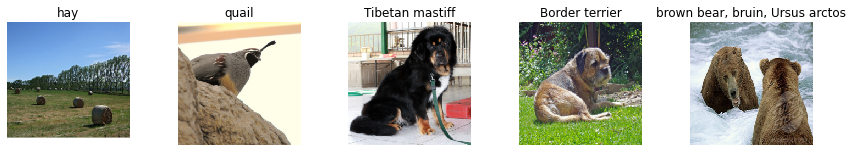

In [74]:
X, y, class_names = load_imagenet_val(num=5)

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

## Saliency Maps
A saliency map tells us the degree to which each pixel in the image affects the classification score for that image. To compute it, we compute the gradient of the unnormalized score corresponding to the correct class (which is a scalar) with respect to the pixels of the image. If the image has shape (3, H, W) then this gradient will also have shape (3, H, W); for each pixel in the image, this gradient tells us the amount by which the classification score will change if the pixel changes by a small amount. To compute the saliency map, we take the absolute value of this gradient, then take the maximum value over the 3 input channels; the final saliency map thus has shape (H, W) and all entries are nonnegative.

### PyTorch gather method
If `s` is an numpy array of shape `(N, C)` and `y` is a numpy array of shape `(N,)` containing integers `0 <= y[i] < C`, then `s[np.arange(N), y]` is a numpy array of shape `(N,)` which selects one element from each element in `s` using the indices in `y`.

In PyTorch you can perform the same operation using the `gather()` method. If `s` is a PyTorch Tensor of shape `(N, C)` and `y` is a PyTorch Tensor of shape `(N,)` containing longs in the range `0 <= y[i] < C`, then `s.gather(1, y.view(-1, 1)).squeeze()` will be a PyTorch Tensor of shape `(N,)` containing one entry from each row of `s`, selected according to the indices in `y`.



In [75]:
def gather_example():
    N, C = 4, 5
    s = torch.randn(N, C)
    y = torch.LongTensor([1, 2, 1, 3])
    print(s)
    print(y)
    print(s.gather(1, y.view(-1, 1)).squeeze())
gather_example()

tensor([[-1.1009, -0.5573, -0.9077,  0.7059,  1.6138],
        [ 1.4554, -1.0741, -0.4927, -0.8190,  0.1059],
        [-0.4465,  1.3168,  0.5870, -0.5511,  1.1027],
        [ 1.0418, -0.1383, -0.7903, -0.1930,  1.0378]])
tensor([1, 2, 1, 3])
tensor([-0.5573, -0.4927,  1.3168, -0.1930])


In [76]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    saliency = None
    ##############################################################################
    # TODO: Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores (we'll combine losses across a batch by summing), and then compute  #
    # the gradients with a backward pass.                                        #
    ##############################################################################
    
    # Set the model on Eval Mode
    model.eval() 

    # Set the requires_grad_ to the image for retrieving gradients
    X = X.requires_grad_()

    # Retrieve outputs from the image
    outputs = model(X)

    # Catch the output. Take the scores in corresponding to the actual labels - `y`
    scores = outputs.gather(1, y.view(-1, 1)).squeeze() 

    # Do backpropagation to get the derivative of the output based on the inputs 
    scores.backward(torch.ones(scores.size())) # provide an inital state (gradient with the same shape)

    # Retireve the saliency map and also pick the maximum value from channels on each pixel.
    # In this case, we look at dim=1. Recall the shape (batch_size, channel, width, height)    
    saliency = torch.max(X.grad.data.abs(), dim=1)[0].squeeze()

    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

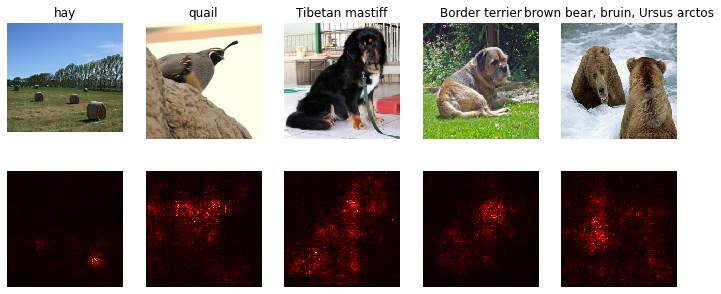

In [77]:
def show_saliency_maps(X, y):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = torch.LongTensor(y)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)
    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

show_saliency_maps(X, y)

## Fooling classifiers

We can also use image gradients to generate "fooling images". Given an image and a target class, we can perform gradient ascent over the image to maximize the target class, stopping when the network classifies the image as the target class. Implement the following function to generate fooling images.

In [78]:
def make_fooling_image(X, target_y, model):
    """
    Generate a fooling image that is close to X, but that the model classifies
    as target_y.

    Inputs:
    - X: Input image; Tensor of shape (1, 3, 224, 224)
    - target_y: An integer in the range [0, 1000)
    - model: A pretrained CNN

    Returns:
    - X_fooling: An image that is close to X, but that is classifed as target_y
    by the model.
    """
    # Initialize our fooling image to the input image, and make it require gradient
    X_fooling = X.clone()
    X_fooling = X_fooling.requires_grad_()
    
    learning_rate = 1
    ##############################################################################
    # TODO: Generate a fooling image X_fooling that the model will classify as   #
    # the class target_y. You should perform gradient ascent on the score of the #
    # target class, stopping when the model is fooled.                           #
    # When computing an update step, first normalize the gradient:               #
    #   dX = learning_rate * g / ||g||_2                                         #
    #                                                                            #
    # You should write a training loop.                                          #
    #                                                                            #
    # HINT: For most examples, you should be able to generate a fooling image    #
    # in fewer than 100 iterations of gradient ascent.                           #
    # You can print your progress over iterations to check your algorithm.       #
    ##############################################################################
    
    i = 0
    y_prediction = None

    print(f'Y Target is: {target_y}')
    while y_prediction != target_y:
        
        # Forward pass + Predictions 
        outputs = model(X_fooling)
        y_prediction = torch.argmax(outputs, dim=1)
        
        # Get the score of the target class
        target_class_score = outputs[0, target_y]
        
        # Backpropogation
        target_class_score.backward()
        
        # Gradient Ascent,  dX = learning_rate * g / ||g||_2 
        g = X_fooling.grad
        X_fooling.data += learning_rate * (g / g.norm())
        
        print(f'i = {i}: model predicted class {y_prediction.item()}')
        i += 1       

    print("Model was Fooled within - {} iterations".format(i))

    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return X_fooling

In [79]:
idx = 2
target_y = 443

X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
X_fooling = make_fooling_image(X_tensor[idx:idx+1], target_y, model)

scores = model(X_fooling)
assert target_y == scores.data.max(1)[1][0].item(), 'The model is not fooled!'

Y Target is: 443
i = 0: model predicted class 244
i = 1: model predicted class 244
i = 2: model predicted class 244
i = 3: model predicted class 244
i = 4: model predicted class 244
i = 5: model predicted class 244
i = 6: model predicted class 244
i = 7: model predicted class 244
i = 8: model predicted class 244
i = 9: model predicted class 214
i = 10: model predicted class 214
i = 11: model predicted class 214
i = 12: model predicted class 214
i = 13: model predicted class 214
i = 14: model predicted class 191
i = 15: model predicted class 443
Model was Fooled within - 16 iterations


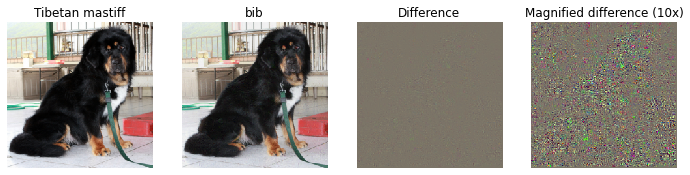

In [80]:
X_fooling_np = deprocess(X_fooling.clone())
X_fooling_np = np.asarray(X_fooling_np).astype(np.uint8)

plt.subplot(1, 4, 1)
plt.imshow(X[idx])
plt.title(class_names[y[idx]])
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(X_fooling_np)
plt.title(class_names[target_y])
plt.axis('off')

plt.subplot(1, 4, 3)
X_pre = preprocess(Image.fromarray(X[idx]))
diff = np.asarray(deprocess(X_fooling - X_pre, should_rescale=False))
plt.imshow(diff)
plt.title('Difference')
plt.axis('off')

plt.subplot(1, 4, 4)
diff = np.asarray(deprocess(10 * (X_fooling - X_pre), should_rescale=False))
plt.imshow(diff)
plt.title('Magnified difference (10x)')
plt.axis('off')

plt.gcf().set_size_inches(12, 5)
plt.show()

The End